[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biodatlab/deep-learning-skooldio/blob/master/02_handwritten_recognition.ipynb)

## **Thai-digit handwritten classification with Pytorch**

This notebook contains a hands-on code for Deep learning class "Thai-digit handwritten classification with Pytorch" by Skooldio

## **Download and clean the dataset from the repository**

- We have downloaded the data from https://github.com/kittinan/thai-handwriting-number by cloning the repository
- Remove files that have character mismatch (as suggested by the the creator)
- Then, we put the cleaned data at https://github.com/biodatlab/deep-learning-skooldio

In [1]:
!git clone https://github.com/biodatlab/deep-learning-skooldio

Cloning into 'deep-learning-skooldio'...
remote: Enumerating objects: 1974, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 1974 (delta 140), reused 226 (delta 116), pack-reused 1706
Receiving objects: 100% (1974/1974), 14.75 MiB | 25.81 MiB/s, done.
Resolving deltas: 100% (151/151), done.


In [2]:
import os
import os.path as op
from glob import glob
from pathlib import Path

In [3]:
directory = "deep-learning-skooldio/"
paths = glob(op.join(directory, "thai-handwritten-dataset", "*", "*"))

In [4]:
from collections import Counter
Counter([Path(p).parent.name for p in paths])

Counter({'8': 175,
         '0': 175,
         '9': 175,
         '6': 175,
         '2': 175,
         '4': 175,
         '7': 175,
         '5': 175,
         '1': 175,
         '3': 175})

In [5]:
from PIL import Image

9


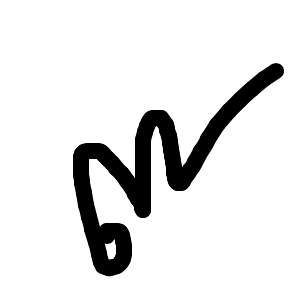

In [6]:
idx = 460
print(Path(paths[idx]).parent.name)
Image.open(paths[idx])

In [7]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import shutil

train_paths, test_paths = train_test_split(paths, test_size=0.1, random_state=42)

In [8]:
for i in range(10):
    os.makedirs(f"data/train/{i}", exist_ok=True)
    os.makedirs(f"data/validation/{i}", exist_ok=True)

In [9]:
def copy_to_destination(src_paths, dst_path: str = "data/train/"):
    for path in tqdm(src_paths):
        path = Path(path)
        if path.parent.name == "10":
            parent_dir = "0"
        else:
            parent_dir = path.parent.name
        shutil.copy(path, op.join(dst_path, parent_dir, path.name))

In [10]:
copy_to_destination(train_paths, "data/train/")
copy_to_destination(test_paths, "data/validation/")

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

In [11]:
len(glob("data/train/*/*")), len(glob("data/validation/*/*"))

(1575, 175)

## **Create a custom dataset and a dataloader**

- We need 3 functions when creating a `Dataset` including `__init__` (typically contains input data and transform), `__len__` (length of the dataset), `__getitem__` (input index then return pair of input and label or input)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [13]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

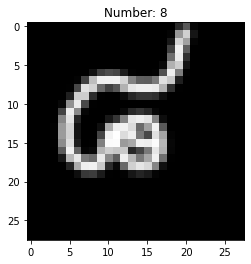

In [14]:
img = Image.open(paths[100])
img = (1 - transform(img)).squeeze(0)
plt.title("Number: {}".format(Path(paths[100]).parent.name))
plt.imshow(img, cmap="gray")
plt.show()

In [15]:
class ThaiDigitDataset(Dataset):
    def __init__(self, img_dir: str, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(p, Path(p).parent.name) for p in glob(op.join(img_dir, "*", "*"))]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image, label = self.img_labels[idx]
        label = int(label)
        image = Image.open(image)
        if self.transform:
            image = 1 - self.transform(image)
        return image, label

In [16]:
train_thaidigit_dataset = ThaiDigitDataset("data/train/", transform=transform)
val_thaidigit_dataset = ThaiDigitDataset("data/validation/", transform=transform)

In [17]:
train_loader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

In [18]:
# load example batch
images, labels = next(iter(train_loader))

In [19]:
images.shape, labels

(torch.Size([16, 1, 28, 28]),
 tensor([5, 5, 1, 7, 2, 6, 2, 5, 4, 3, 6, 3, 8, 6, 0, 2]))

## **Create the model**

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class ThaiDigitNet(nn.Module):
    def __init__(self):
        super(ThaiDigitNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [21]:
net = ThaiDigitNet()
images, labels = next(iter(train_loader))
pred = net(images)

In [22]:
images.shape, pred.shape # check the size

(torch.Size([16, 1, 28, 28]), torch.Size([16, 10]))

## **Train the model**

**Note for loss function**
- `CrossEntropyLoss` computes the cross entropy loss between logits and target. So we don't need to apply softmax to the output of the model.
- This is equivalent to the combination of applying `LogSoftmax` at the last layer and use `NLLLoss` as a loss function.

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
update_steps = 50
n_epochs = 50

for epoch in range(n_epochs):
    # training
    net.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        pred = net(images)
        loss = loss_fn(pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % update_steps == 0:
            print(f"loss: {loss.item()} [epoch: {epoch} / # {batch_idx * len(images)}]")

    # validation
    net.eval()
    val_loss, correct = 0, 0
    n_val = len(val_loader.dataset)
    for images, labels in val_loader:
        pred = net(images)
        val_loss += loss_fn(pred, labels).item()
        correct += (pred.argmax(1) == labels).float().sum().item()
    print(f"validation accuracy = {correct / n_val}, average loss = {val_loss / len(val_loader)}")

loss: 2.3162765502929688 [epoch: 0 / # 0]
loss: 2.263861894607544 [epoch: 0 / # 800]
validation accuracy = 0.2057142857142857, average loss = 2.2661554379896685
loss: 2.2488739490509033 [epoch: 1 / # 0]
loss: 2.2315127849578857 [epoch: 1 / # 800]
validation accuracy = 0.38285714285714284, average loss = 2.2194258949973364
loss: 2.222292184829712 [epoch: 2 / # 0]
loss: 2.1528196334838867 [epoch: 2 / # 800]
validation accuracy = 0.45714285714285713, average loss = 2.160855943506414
loss: 2.209303379058838 [epoch: 3 / # 0]
loss: 2.1052567958831787 [epoch: 3 / # 800]
validation accuracy = 0.4685714285714286, average loss = 2.0878803838383067
loss: 2.0863046646118164 [epoch: 4 / # 0]
loss: 2.1570541858673096 [epoch: 4 / # 800]
validation accuracy = 0.44, average loss = 2.0009248473427514
loss: 1.9586087465286255 [epoch: 5 / # 0]
loss: 2.094212293624878 [epoch: 5 / # 800]
validation accuracy = 0.49714285714285716, average loss = 1.9063133976676248
loss: 1.9852724075317383 [epoch: 6 / # 0]
lo

## **Use the model**

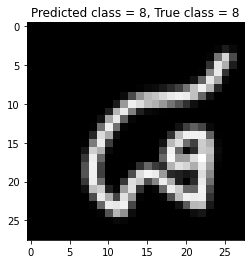

In [30]:
sample_path = glob("data/validation/*/*.png")[1]
img = Image.open(sample_path)
img = (1 - transform(img)).squeeze(0)
pred = net(img)
pred = int(pred.argmax(dim=1))
true_class = Path(sample_path).parent.name

plt.title("Predicted class = {}, True class = {}".format(pred, true_class))
plt.imshow(img, cmap="gray")
plt.show()

## Save model

- `net.state_dict()` returns the dictionary of the model's parameters. We can save it to a file and load it later.

In [43]:
net.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.0068, -0.0363, -0.0182,  ..., -0.0040,  0.0027, -0.0224],
                      [ 0.0254,  0.0180,  0.0130,  ..., -0.0240,  0.0361, -0.0357],
                      [ 0.0047,  0.0095, -0.0038,  ...,  0.0373, -0.0178, -0.0248],
                      ...,
                      [ 0.0316,  0.0168,  0.0027,  ...,  0.0009,  0.0090,  0.0166],
                      [ 0.0121, -0.0264, -0.0399,  ..., -0.0264,  0.0246, -0.0317],
                      [-0.0092, -0.0217,  0.0303,  ...,  0.0006, -0.0249, -0.0256]])),
             ('fc1.bias',
              tensor([-0.1210,  0.1649,  0.1954,  0.0031, -0.0120, -0.0491,  0.0365,  0.0128,
                      -0.1349,  0.0757,  0.0655,  0.0638, -0.0870,  0.0143,  0.0633, -0.0709,
                       0.1478, -0.0843,  0.0613,  0.0387,  0.0969,  0.1362, -0.0567,  0.1266,
                      -0.0069,  0.1506,  0.1809, -0.0434, -0.0436, -0.0939, -0.0226, -0.1228,
                       0.0843,  0.12

In [44]:
net.state_dict()["fc1.weight"].shape, net.state_dict()["fc1.bias"].shape

(torch.Size([100, 784]), torch.Size([100]))

In [45]:
save_path = "thai_digit.pth"
torch.save(net.state_dict(), save_path)